In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Step 1 : Importing Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaModel, RobertaTokenizer,get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time


In [3]:
# Step 2 : Preparing dataset
# Load the dataset
file_path = '42_augmented_synonym_clean.csv' #'cleaned_70_jobs_merge_real_aug.csv'
df = pd.read_csv(file_path)
df.head()




,Title,Description
0,Receptionist,AMERIA Closed Joint Stock Company seeking Rece...
1,Receptionist,VTnova LLC invite application highly qualified...
2,Lawyer,UMCOR United Methodist Committee Relief Armeni...
3,Lawyer,ACRA Credit Bureau announcing open position at...
4,Cook,Committed person fulfil position Chief Cook


In [4]:
df.shape

(17370, 2)

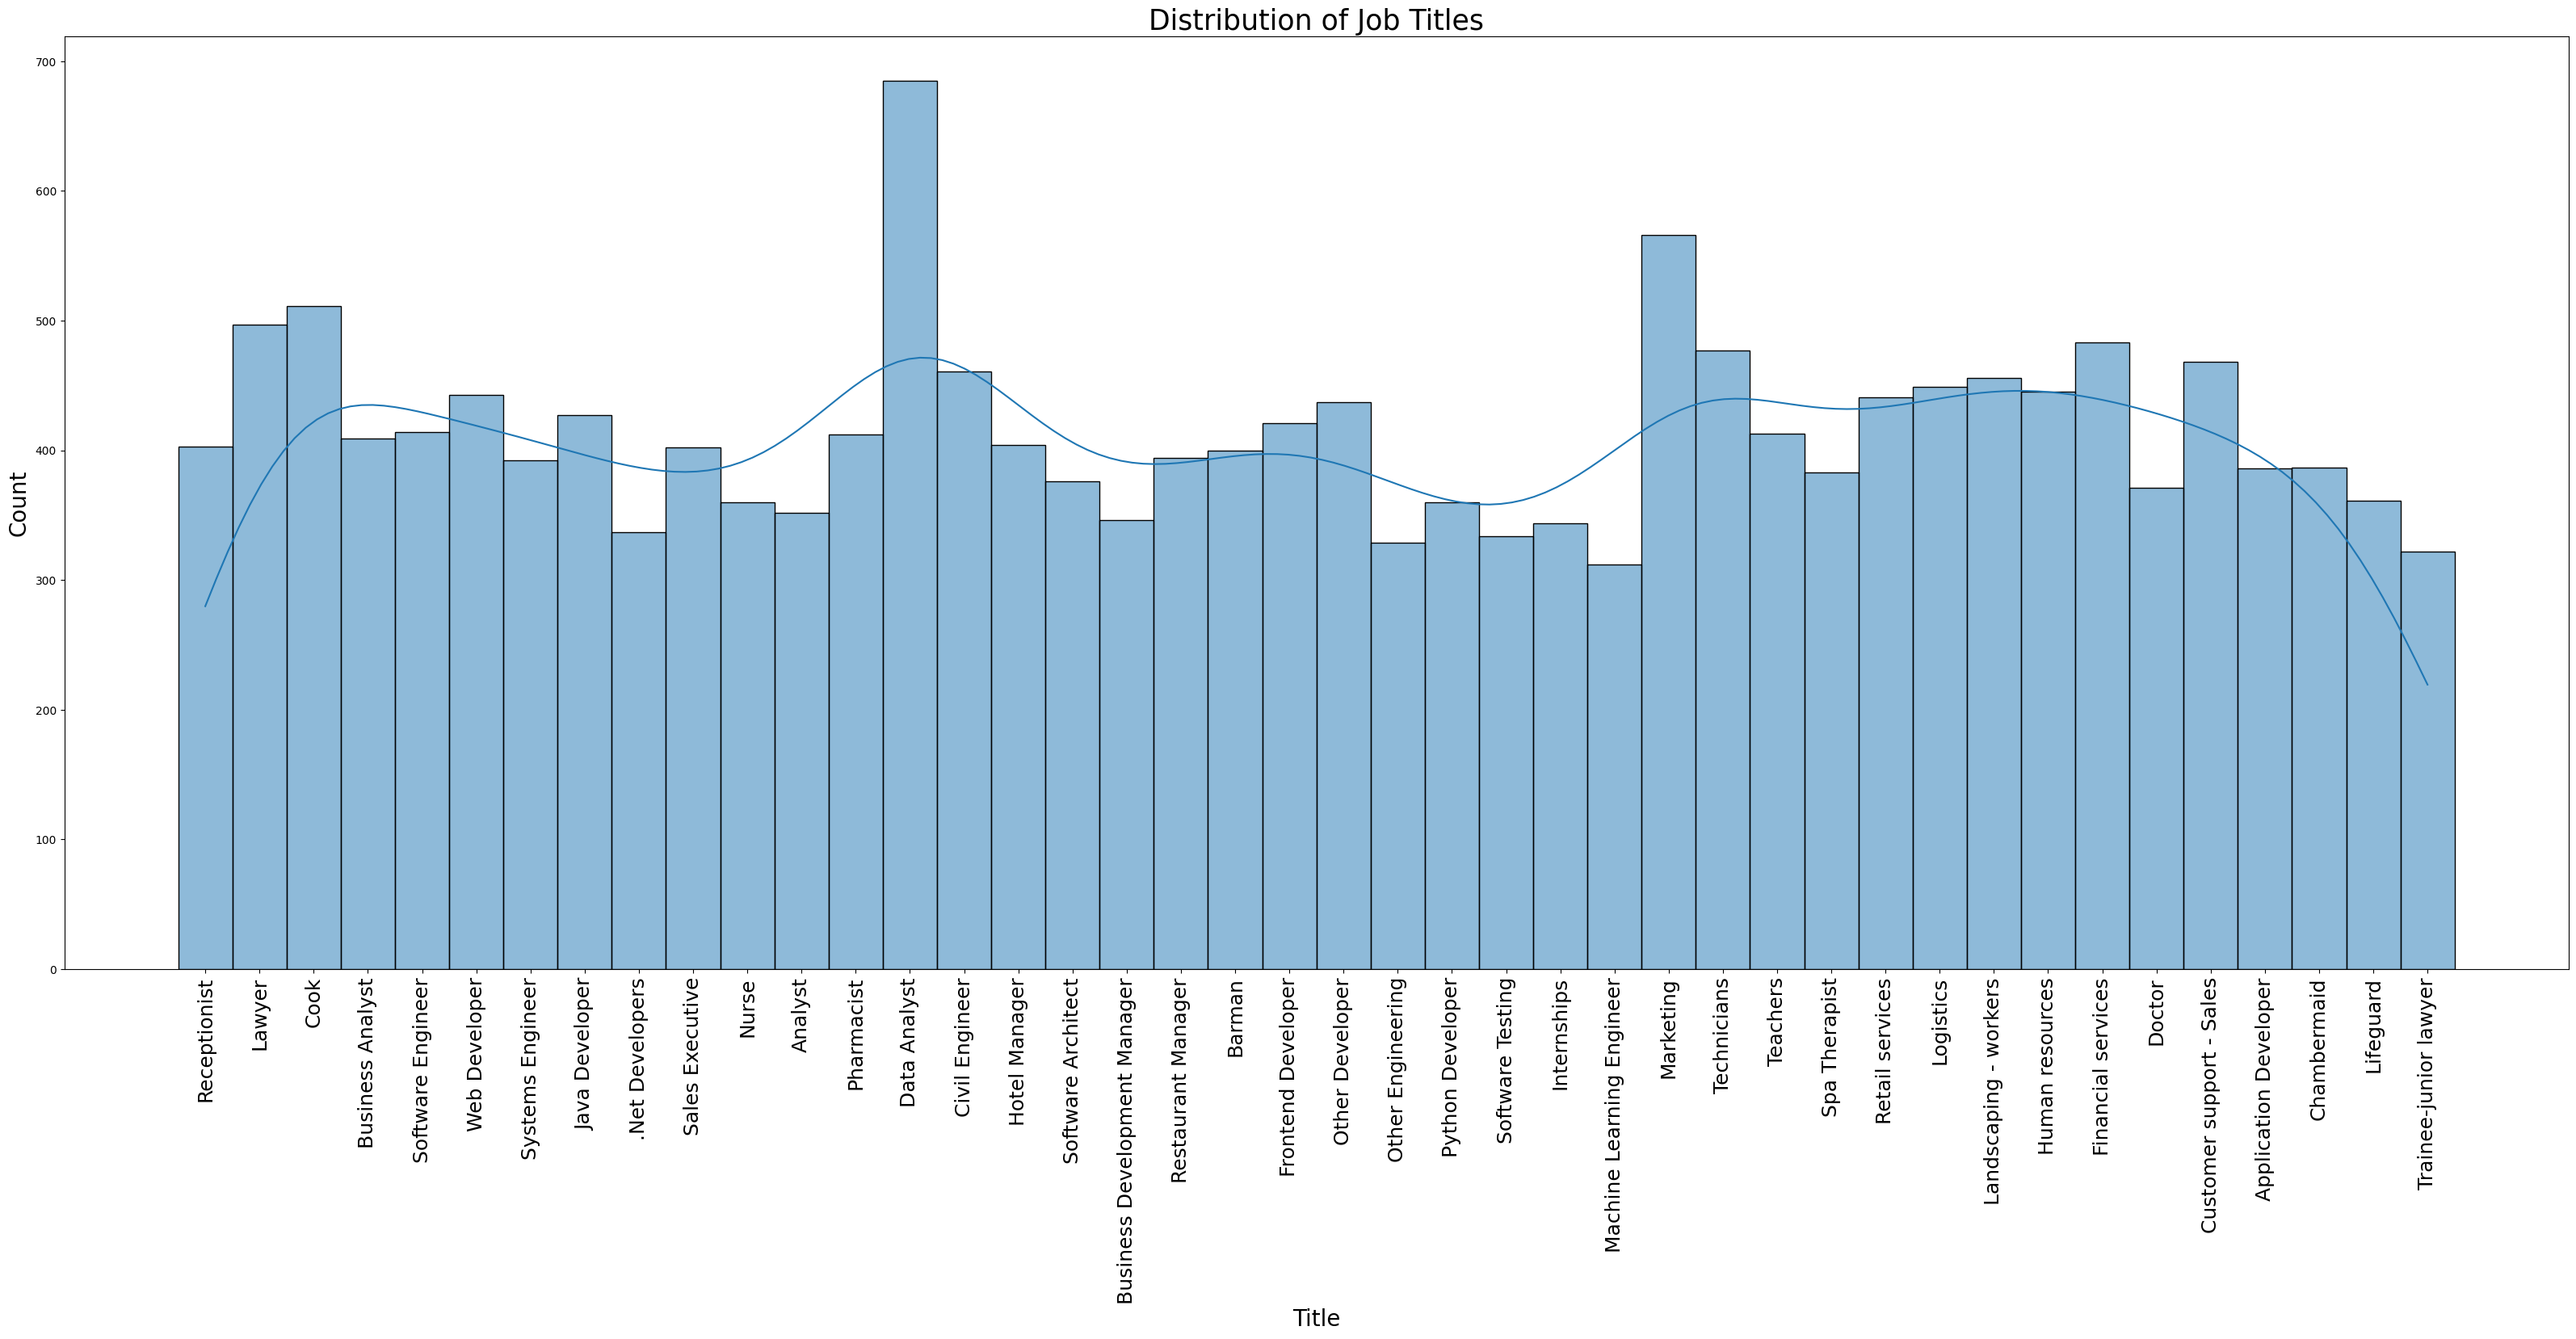

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 15))
sns.histplot(x=df['Title'], kde=True)

# Set larger font size for x-axis labels
plt.xticks(rotation=90, fontsize=18)

# Set larger font size for x and y axis labels
plt.xlabel('Title', fontsize=20)
plt.ylabel('Count', fontsize=20)

# Set larger font size for title
plt.title('Distribution of Job Titles', fontsize=25)

plt.show()

In [6]:
# Initialize the tokenizer
tokenizer = tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Label encoding for the 'Title' column
label_encoder = LabelEncoder()
df['Title'] = label_encoder.fit_transform(df['Title'])

# Split the dataset into training, validation, and testing sets (80%, 10%, 10%)
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_texts, val_texts, test_texts = np.split(df.sample(frac=1, random_state=42), [train_size, train_size + val_size])

# Tokenize the texts
def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(train_texts['Description'])
val_encodings = tokenize_function(val_texts['Description'])
test_encodings = tokenize_function(test_texts['Description'])

C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
class JobMatchingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Create the dataset objects
train_dataset = JobMatchingDataset(train_encodings, train_texts['Title'])
val_dataset = JobMatchingDataset(val_encodings, val_texts['Title'])
test_dataset = JobMatchingDataset(test_encodings, test_texts['Title'])


In [8]:
# Step 4 : Defining Job Matching Model
class JobMatchingModel(nn.Module):
    def __init__(self, roberta_model):
        super(JobMatchingModel, self).__init__()
        self.roberta = roberta_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, len(label_encoder.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


In [9]:
# Step 5 : Preparing data loader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [10]:
#Step 6 : Model Training setup

num_epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = JobMatchingModel(roberta_model=RobertaModel.from_pretrained('roberta-base'))
model = model.to(device)

# Define optimizer with appropriate hyperparameters
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5,eps=1e-6, weight_decay=0.01)


# Define loss function
criterion = nn.CrossEntropyLoss()

# Total training steps
total_steps = len(train_loader) * num_epochs

# Define the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)




Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#Step 7: Training Loop with Accuracy and Loss Tracking


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

start_time=time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_examples = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_examples

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}, Training Accuracy: {accuracy}')

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_examples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct_predictions += (preds == labels).sum().item()
            val_total_examples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_examples

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

    end_time=time.time()
training_time=end_time-start_time
# Convert the training time to hh:mm:ss format
training_time_hms = time.strftime('%H:%M:%S', time.gmtime(training_time))

print('Total Training Time for RoBERTa: ',training_time_hms)


Epoch 1/4, Training Loss: 1.1993579409407802, Training Accuracy: 0.6883995394358089
Epoch 1/4, Validation Loss: 0.4424608596386986, Validation Accuracy: 0.8808290155440415
Epoch 2/4, Training Loss: 0.35508696070226003, Training Accuracy: 0.9065918249856074
Epoch 2/4, Validation Loss: 0.27603106933791155, Validation Accuracy: 0.9268854346574554
Epoch 3/4, Training Loss: 0.19102597943216698, Training Accuracy: 0.9503454231433506
Epoch 3/4, Validation Loss: 0.2105772761636576, Validation Accuracy: 0.9447322970639033
Epoch 4/4, Training Loss: 0.10898721498524035, Training Accuracy: 0.9736614853195165
Epoch 4/4, Validation Loss: 0.20073077119801433, Validation Accuracy: 0.9493379389752447
Total Training Time for RoBERTa:  00:21:28


In [12]:
# Saving training results in a dataframe
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accuracies
})

results_df.head(10)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,1.199358,0.688400,0.442461,0.880829
1,2,0.355087,0.906592,0.276031,0.926885
2,3,0.191026,0.950345,0.210577,0.944732
3,4,0.108987,0.973661,0.200731,0.949338


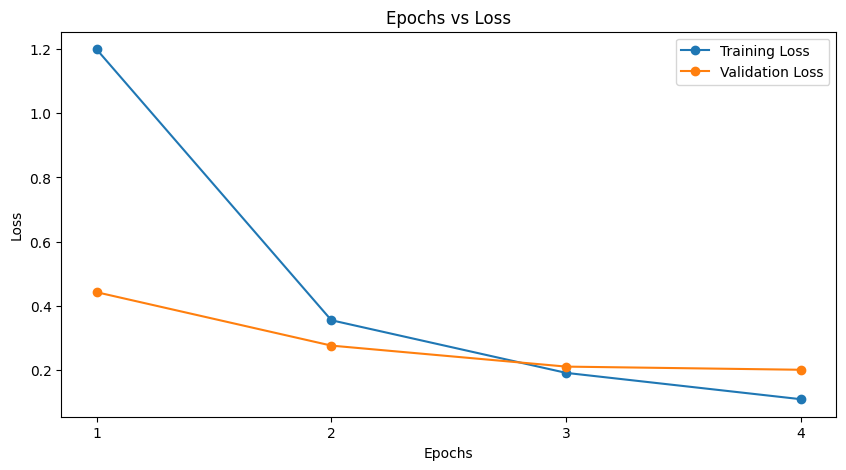

In [13]:
# Plotting Accuracy and Loss Over Epochs
import matplotlib.pyplot as plt
# Plot Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Loss'], marker='o', label='Training Loss')
plt.plot(results_df['Epoch'], results_df['Validation Loss'], marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()



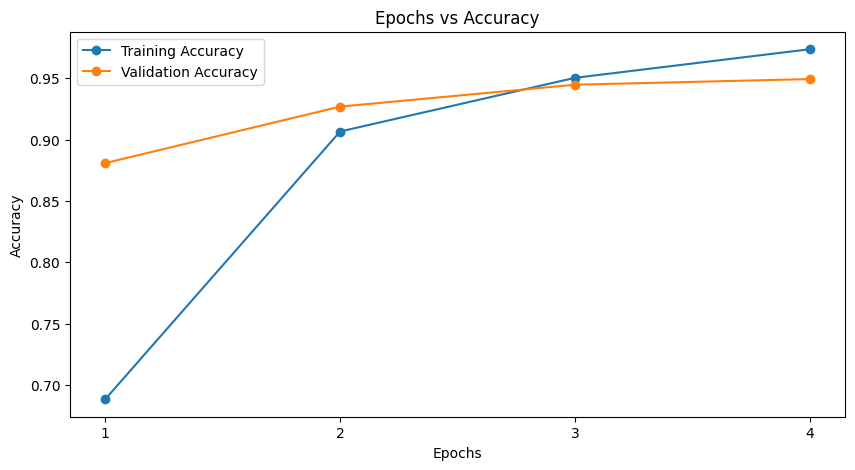

In [14]:
# Plot Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Accuracy'], marker='o', label='Training Accuracy')
plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()

In [15]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions, true_labels = [], []

test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')


Accuracy: 0.9499136442141624, Precision: 0.9504833146120742, Recall: 0.9499136442141624, F1 Score: 0.9498765746610313


In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Finding the number of unique classes in both true labels
unique_classes = np.unique(true_labels)

# Inversely transforming the unique classes to get their names
class_names = label_encoder.inverse_transform(unique_classes)

# Generating the classification report
print(classification_report(true_labels, predictions, labels=unique_classes, target_names=class_names))

                              precision    recall  f1-score   support

             .Net Developers       1.00      0.91      0.95        34
                     Analyst       0.82      0.80      0.81        35
       Application Developer       1.00      1.00      1.00        34
                      Barman       1.00      1.00      1.00        39
            Business Analyst       0.90      0.90      0.90        49
Business Development Manager       0.95      0.92      0.94        39
                 Chambermaid       1.00      1.00      1.00        36
              Civil Engineer       0.98      0.95      0.96        42
                        Cook       1.00      0.98      0.99        54
    Customer support - Sales       0.98      0.96      0.97        46
                Data Analyst       0.81      0.84      0.83        57
                      Doctor       1.00      1.00      1.00        32
          Financial services       0.96      0.93      0.94        55
          Frontend 

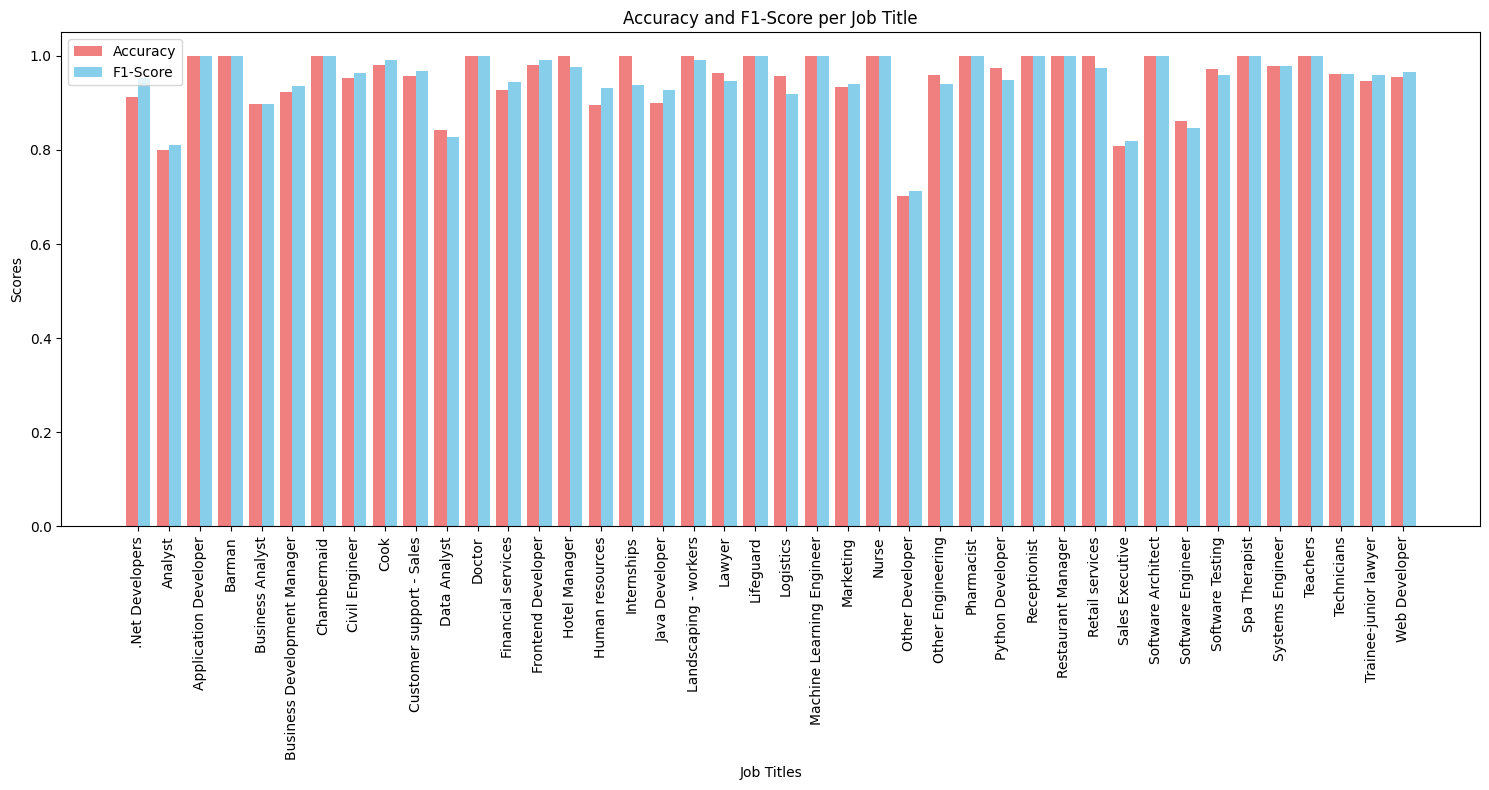

In [17]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Convert true_labels and predictions to numpy arrays (if they aren't already)
true_labels_np = np.array(true_labels)
predictions_np = np.array(predictions)

# Get the classification report as a dictionary
report = classification_report(true_labels_np, predictions_np, labels=unique_classes, target_names=class_names, output_dict=True)

# Extract the F1-scores for each class
f1_scores = [report[title]['f1-score'] for title in label_encoder.classes_]

# Calculate the accuracy per class
accuracy_per_class = []
for i, title in enumerate(label_encoder.classes_):
    # Mask to filter only the samples that belong to class i
    class_mask = (true_labels_np == i)
    
    # Calculate accuracy for class i
    class_accuracy = accuracy_score(true_labels_np[class_mask], predictions_np[class_mask])
    accuracy_per_class.append(class_accuracy)

# Plotting the F1-scores and Accuracy for each class
plt.figure(figsize=(15, 8))
x = np.arange(len(label_encoder.classes_))

# Plot accuracy and F1-score with gentle colors
plt.bar(x - 0.2, accuracy_per_class, 0.4, label='Accuracy', color='#F08080')  # Peach
plt.bar(x + 0.2, f1_scores, 0.4, label='F1-Score', color='#87CEEB')  # Lavender

# Customize the plot
plt.xticks(x, label_encoder.classes_, rotation=90)
plt.xlabel('Job Titles')
plt.ylabel('Scores')
plt.title('Accuracy and F1-Score per Job Title')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


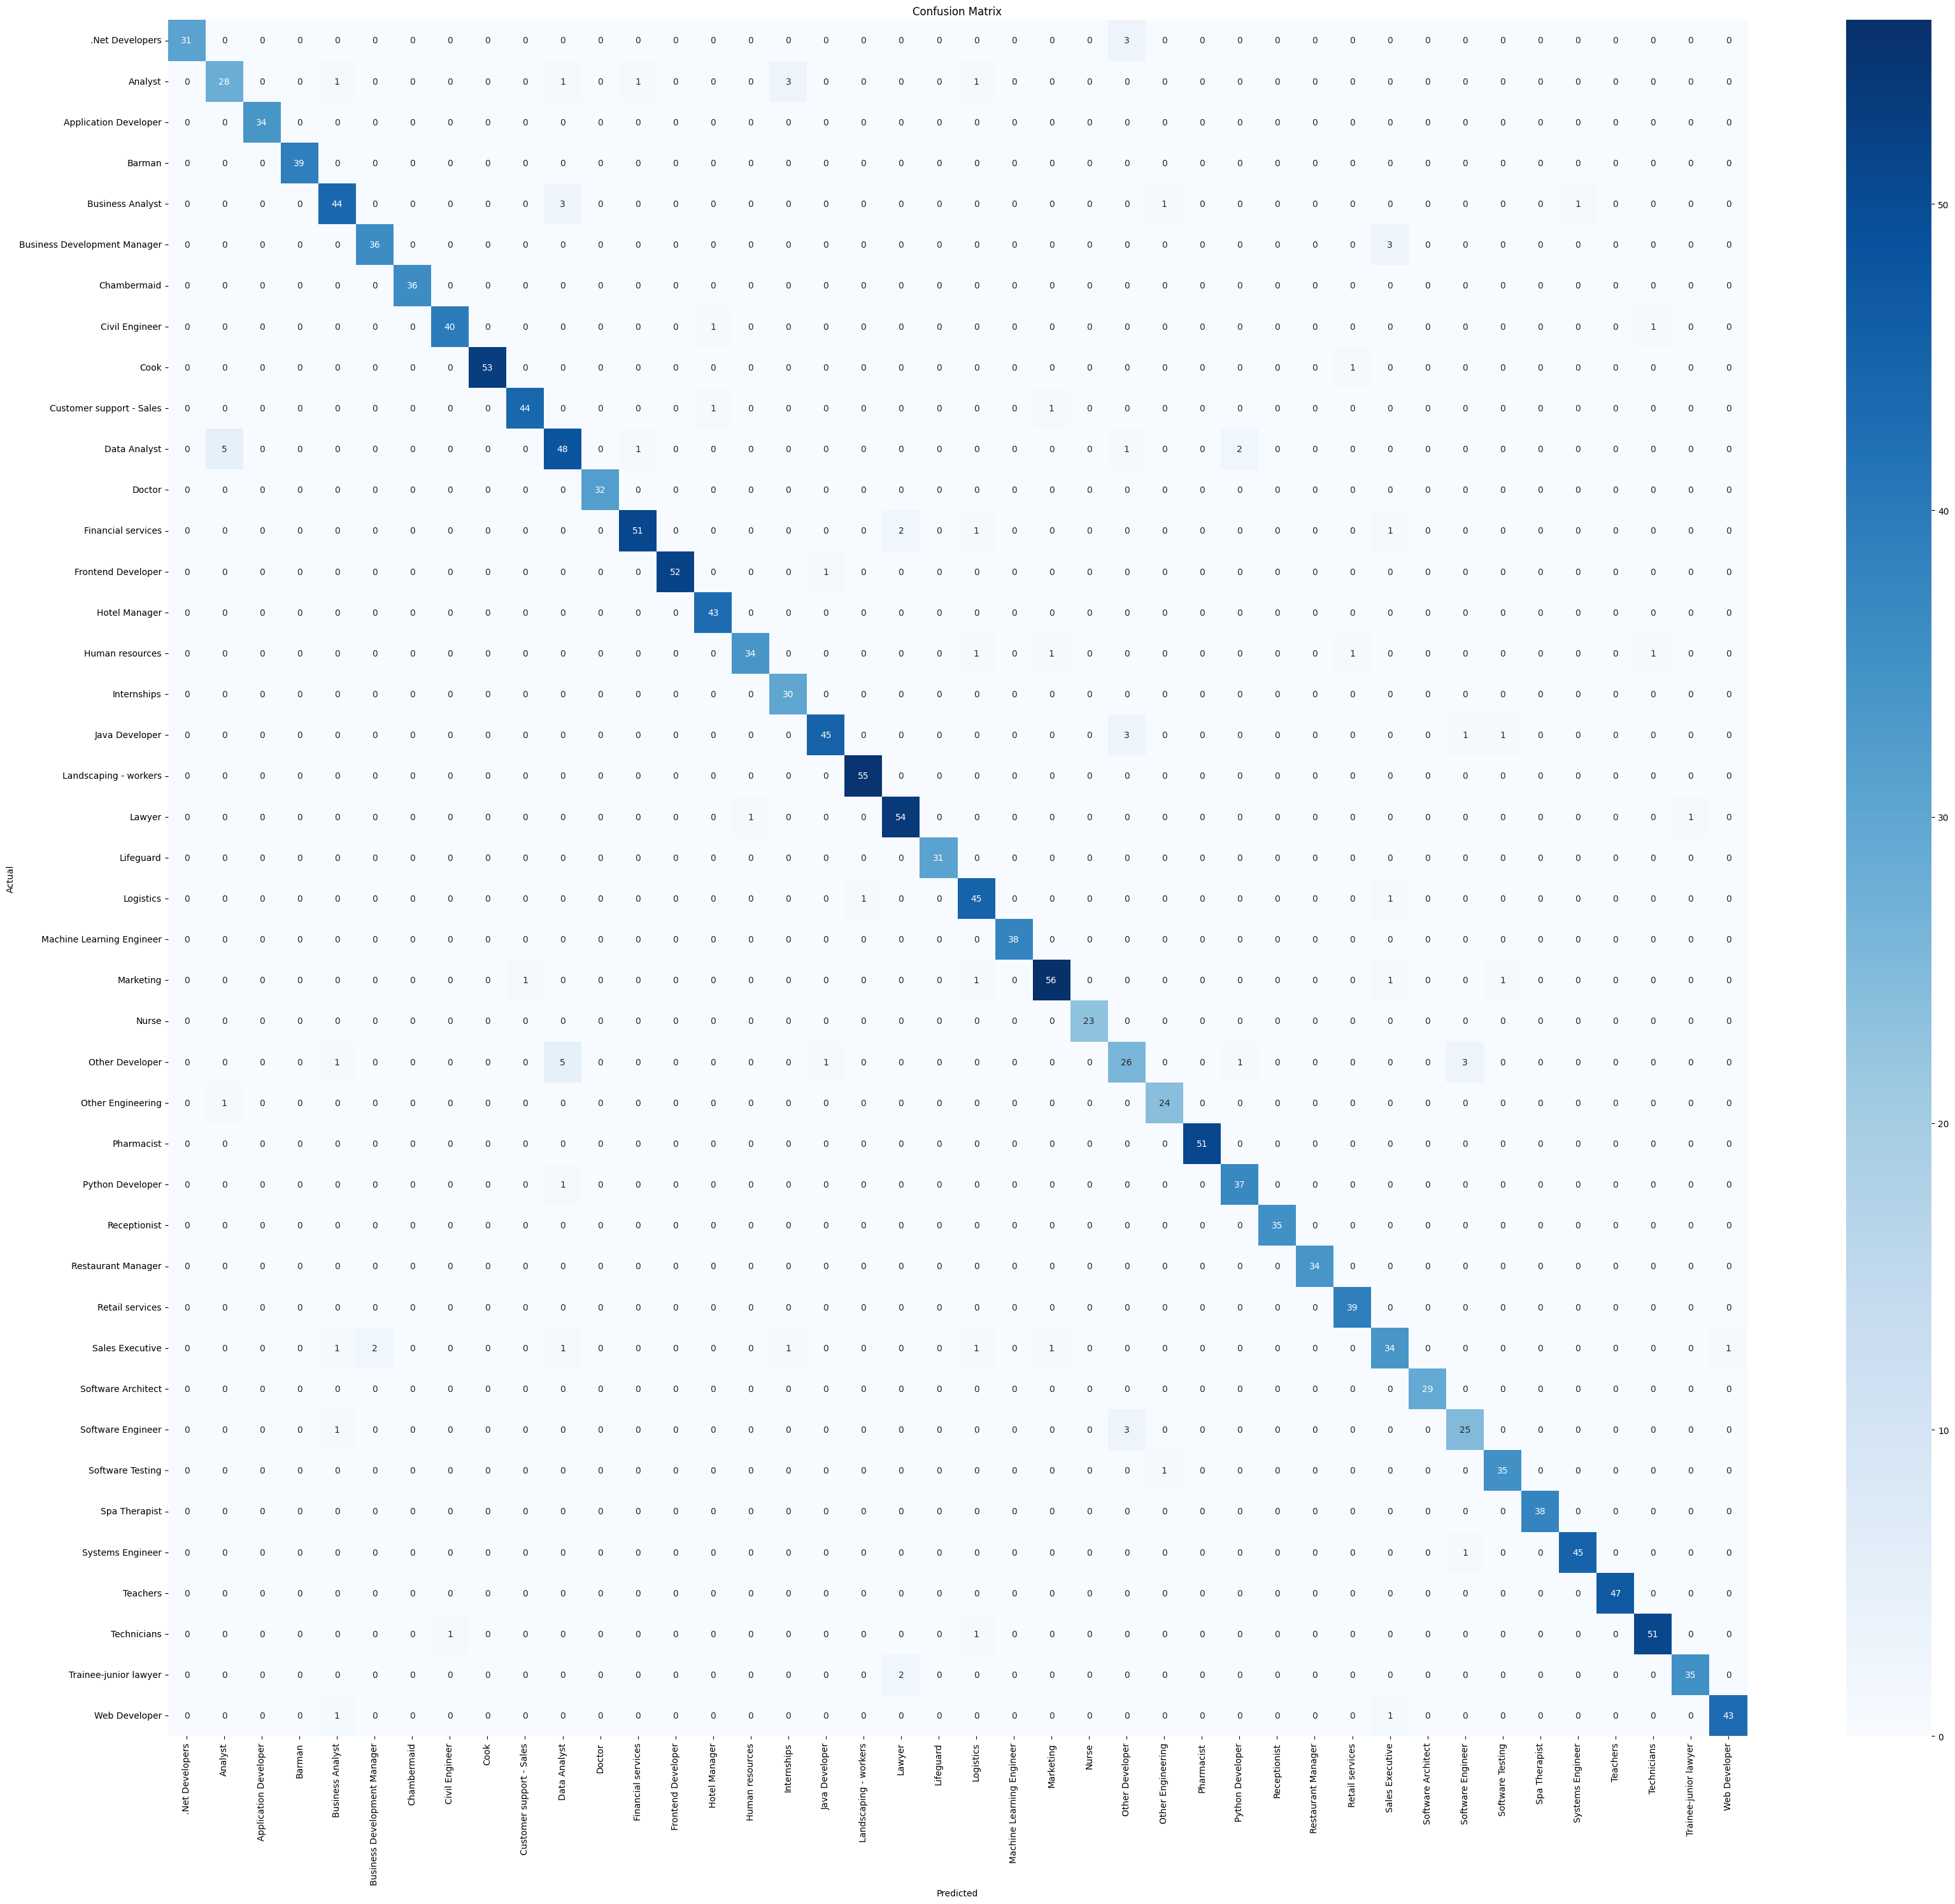

In [18]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(40,35))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


#### Saving Model

In [19]:
# Assuming 'model' is your trained RoBERTa model
model_save_path = 'roberta_job_matching_model.pth'
torch.save(model.state_dict(), model_save_path)

#### Making Predictions

In [20]:
# Load the RoBERTa model
roberta_model = JobMatchingModel(roberta_model=RobertaModel.from_pretrained('roberta-base'))
roberta_model.load_state_dict(torch.load('roberta_job_matching_model.pth'))
roberta_model.to(device)

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
import nltk  # Natural Language Toolkit, a comprehensive library for working with human language data.
import re # regular expressions, allowing for complex string searching and manipulation.
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, sent_tokenize, word_tokenize  # NLTK (Natural Language Toolkit) for natural language processing: pos_tag for part-of-speech tagging, sent_tokenize for sentence tokenization, word_tokenize for word tokenization.
from nltk.corpus import stopwords  # Provides a list of 'stopwords' that can be filtered out from text data.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AIMVLab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:

def cleanResume(txt):
    # Ensure input is a string
    if isinstance(txt, str):
        # Remove URLs
        cleanText = re.sub('http\S+\s', ' ', txt)
        # Remove hashtags
        cleanText = re.sub('#\S+\s', ' ', cleanText)
        # Remove mentions
        cleanText = re.sub('@\S+', '  ', cleanText)
        # Remove punctuation
        cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
        # Remove non-ASCII characters
        cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
        # Normalize whitespace
        cleanText = re.sub('\s+', ' ', cleanText)

        sentences = sent_tokenize(cleanText) # Tokenize the text into sentences
        features = '' # Initialize the output text
        stop_words = set(stopwords.words("english")) # Define English stop words
        lemmatizer = WordNetLemmatizer() # Initialize the WordNet lemmatizer

        for sent in sentences:
            words = word_tokenize(sent) # Tokenize the sentence into words
            words = [word for word in words if word not in stop_words] # Filter out stop words
            tagged_words = pos_tag(words) # Tag words with their parts of speech
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']] # Filter out certain POS tags
            lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words] # Lemmatize the filtered words
            features += " ".join(lemmatized_words) + " " # Add lemmatized words to features

        return features.strip() # Return the processed features, stripped of any extra spaces
    else:
        return txt  # Return the input as is if it's not a string


In [23]:
# myresume = """I am a data scientist specializing in machine
# learning, deep learning, and computer vision. With
# a strong background in mathematics, statistics,
# and programming, I am passionate about
# uncovering hidden patterns and insights in data.
# I have extensive experience in developing
# predictive models, implementing deep learning
# algorithms, and designing computer vision
# systems. My technical skills include proficiency in
# Python, Sklearn, TensorFlow, and PyTorch.
# What sets me apart is my ability to effectively
# communicate complex concepts to diverse
# audiences. I excel in translating technical insights
# into actionable recommendations that drive
# informed decision-making.
# If you're looking for a dedicated and versatile data
# scientist to collaborate on impactful projects, I am
# eager to contribute my expertise. Let's harness the
# power of data together to unlock new possibilities
# and shape a better future.
# Contact & Sources
# Email: 611noorsaeed@gmail.com
# Phone: 03442826192
# Github: https://github.com/611noorsaeed
# Linkdin: https://www.linkedin.com/in/noor-saeed654a23263/
# Blogs: https://medium.com/@611noorsaeed
# Youtube: Artificial Intelligence
# ABOUT ME
# WORK EXPERIENCE
# SKILLES
# NOOR SAEED
# LANGUAGES
# English
# Urdu
# Hindi
# I am a versatile data scientist with expertise in a wide
# range of projects, including machine learning,
# recommendation systems, deep learning, and computer
# vision. Throughout my career, I have successfully
# developed and deployed various machine learning models
# to solve complex problems and drive data-driven
# decision-making
# Machine Learnine
# Deep Learning
# Computer Vision
# Recommendation Systems
# Data Visualization
# Programming Languages (Python, SQL)
# Data Preprocessing and Feature Engineering
# Model Evaluation and Deployment
# Statistical Analysis
# Communication and Collaboration
# """
# cleaned_resume = cleanResume(myresume)


In [24]:
# myresume='''The primary role of a Business Analyst is to bridge the gap between business stakeholders and technology teams, ensuring that the software and systems developed align with business requirements. The following is a comprehensive job description for a Business Analyst:

# Job Title: Business Analyst

# Job Summary: The Business Analyst will collaborate with various departments and stakeholders to gather, document, and analyze business requirements, processes, and workflows. They will translate these requirements into functional specifications for technology teams and work closely with project managers, developers, and testers to ensure successful project delivery. The Business Analyst will also be involved in identifying areas for process improvement and recommending solutions to enhance operational efficiency and effectiveness.

# Responsibilities:

# 1. Requirement Elicitation and Analysis:

# Work closely with business stakeholders to understand their needs, objectives, and challenges.
# Elicit, document, and analyze business requirements, processes, and workflows.
# Translate business requirements into clear and concise functional specifications for technical teams.
# 2. Solution Design:

# Collaborate with technology teams to design solutions that meet business needs.
# Propose innovative and practical solutions to address business challenges.
# Ensure that proposed solutions align with the organization's strategic goals and technological capabilities.
# 3. Stakeholder Communication:

# Serve as a liaison between business stakeholders and technology teams.
# Communicate complex technical concepts to non-technical stakeholders.
# Present findings, recommendations, and project updates to various audiences.
# 4. Documentation:

# Create detailed documentation including business requirements, process flows, use cases, and user stories.
# Maintain accurate and up-to-date project documentation throughout the project lifecycle.
# 5. Project Management:

# Collaborate with project managers to define project scope, objectives, and deliverables.
# Assist in project planning, estimation, and resource allocation.
# Monitor project progress and identify potential risks or deviations from the plan.
# 6. Quality Assurance:

# Participate in system testing, user acceptance testing, and validation of implemented solutions.
# Ensure that delivered solutions meet the specified requirements and are of high quality.
# 7. Process Improvement:

# Identify areas for process optimization and efficiency enhancement.
# Recommend process improvements and assist in their implementation.
# Qualifications:

# Bachelor's degree in Business Administration, Information Technology, or a related field (Master's degree is a plus).
# Proven experience as a Business Analyst or in a related role.
# Strong analytical, problem-solving, and critical-thinking skills.
# Excellent communication and interpersonal abilities.
# Proficiency in requirement gathering techniques, process modeling, and documentation.
# Familiarity with project management methodologies and software development lifecycle.
# Ability to collaborate effectively with cross-functional teams.
# Knowledge of relevant tools such as Microsoft Visio, JIRA, Confluence, etc.
# Certification in Business Analysis (e.g., CBAP, CCBA) is advantageous.
# Business Analyst Roles and Responsibilities
# While business analyst roles and responsibilities involve several aspects, the primary role of a business analyst is to make changes within an organization. The solution-oriented changes improve an organization's overall efficiency, including process optimization, cost reduction, and identifying fresh business opportunities. Some of the Business Analyst responsibilities include:
# '''
# cleaned_resume = cleanResume(myresume)




In [25]:
myresume='''Antonio Rollins
045-281-9273 | Rollins@email.com.au | Brisbane, QLD
Professional Summary
Qualified and experienced cook seeking employment with Tanga Cuisines as a senior cook. Developed excellent knowledge of cooking procedures and sanitary compliances from a Bachelor of Culinary Management and several years of experience as a qualified cook. Able to contribute a professional mindset and enthusiasm to the team and Tanga Cuisines. Has a passion for cooking and strives to prepare quality meals for all styles of cuisines. Has specialist skills in pastries and desserts.
Certificates
Culinary Skills 101
Kitchen Management Online Course
Exploring Cuisines Short Course
Advanced French Pastry Course
Italian Cuisine 101
Skills
Time management, enthusiasm, communication, attention to detail, teamwork, collaboration, problem-solving
Work Experience
Cook
Hilltop Cookery
Hilltop, WA
February 2019-February 2022
Assisted in the planning of main course meals
Managed a main course cooking station
Provided instructions for cooking assistants
Followed the directives of a head chef
Ensured cooking stations complied with sanitary regulations
Pastry Chef
Sweet Tooth Pastries
Hedland Way, WA
February 2014-February 2019
Prepared pastry menus
Managed kitchen hands and bakery assistants
Prepared and cleaned cooking equipment
Qualifications
Bachelor of Culinary Management
Valkry University, 2014
Education
Senior Secondary Certificate of Education
Smithtown High School, 2011
Related:
What Does a Line Cook Do? (With Skills and Certifications)
How to Write a Line Cook Resume (with Steps and Examples)
How to Write a Baker Resume: Steps, Templates and Examples
Example resume for a recent graduate
Below, you can review a resume example of a candidate who's recently graduated from a culinary school:
Ralph May
046-657-8263 | May@email.com.au | Perth, WA
Professional Summary
A recent graduate from Genton University with a Bachelor of Culinary Management. Hoping to gain employment with Green Cuisines as a cook and begin developing my professional career in the culinary industry. Has excellent enthusiasm and work ethic to provide to the team at Green Cuisines. Excited to begin a culinary career and turn theoretical knowledge into practical skills.
Skills
Time management, attention to detail, communication, teamwork, collaboration, awareness, creativity, multitasking, commitment, dedication
Work Experience
Cook intern
Horton Restaurant
Horton, WA
February 2019-2022
Assisting senior cooks in completing daily duties
Developing advanced cutting and carving skills
Utilised a variety of cooking equipment
Cleaned and sanitised cooking stations
Followed instructions from a head chef and senior cook
Kitchen hand
Barnett's Kitchen
Hemford Circuit, WA
February 2014-2019
Cleaned cooking equipment and kitchen stations
Assisted cooks and chefs with minor cooking duties
Ensured service areas were clean and presentable
Qualifications
Bachelor of Culinary Management
Genton University, 2014
Education
Senior Secondary Certificate of Education
Tinto High School, 2011'''
cleaned_resume = cleanResume(myresume)

In [26]:
def predict_job_title(model, tokenizer, resume_text):
    # Preprocess and tokenize the resume text
    inputs = tokenizer(
        resume_text,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move inputs to the device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

    # Convert predicted label to job title
    predicted_label = preds.cpu().numpy()[0]
    job_title = label_encoder.inverse_transform([predicted_label])

    return job_title[0]


job_title = predict_job_title(model, tokenizer, cleaned_resume)
print(f'Predicted Job Title: {job_title}')


Predicted Job Title: Cook
